In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import random

from scipy.integrate import solve_ivp
import torch 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import pysindy as ps

# Генерация данных как в CRNN-модели

In [20]:
def true_ode_func(t, y, k):
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : array-like
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : array-like
        Коэффициенты (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    dydt = np.zeros_like(y)
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

In [21]:
# Константы

N_REACTION = 4                                                       # реакций
N_SUBSTANCE = 5                                                      # веществ
VR_TIME = 30                                                         # время прохождения реакций
INIT_CONC = np.array([0.8, 0.5, 0.1, 0, 0])
k = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)

tspan = [0.0, VR_TIME]                                               # временной промежуток
tsteps = np.linspace(tspan[0], tspan[1], VR_TIME + 1)                # шаги по временному промежутку (количество точек)

Стехиометрическая матрица в базовом виде

In [22]:
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

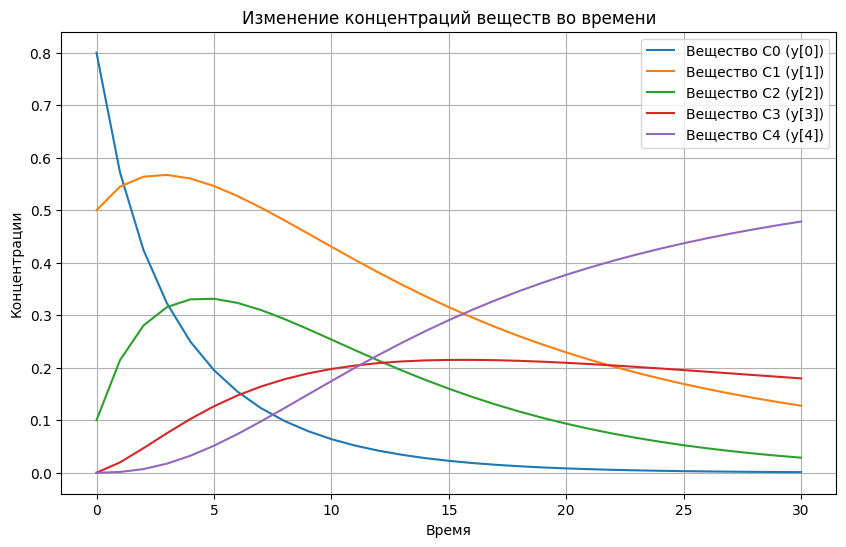

Начальные концентрации:        [0.8 0.5 0.1 0.  0. ]
Сумма концентраций веществ:  1.4000000000000001
Концентрации после 30 секунд: [0.00135553 0.1347056  0.03239029 0.18281589 0.47134237]
Сумма концентрций веществ:  0.8226096690921885


In [23]:
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        INIT_CONC,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество C{i} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", INIT_CONC)
print("Сумма концентраций веществ: ", sum(INIT_CONC))
print(f"Концентрации после {VR_TIME} секунд: {sol.y[:, VR_TIME - 1]}")
print("Сумма концентрций веществ: ", sum(sol.y[:, VR_TIME - 1]))

In [24]:
true_values = sol.y.copy()    # сохранение промежуточных результатов. Понадобятся в будущем

## Добавление шума

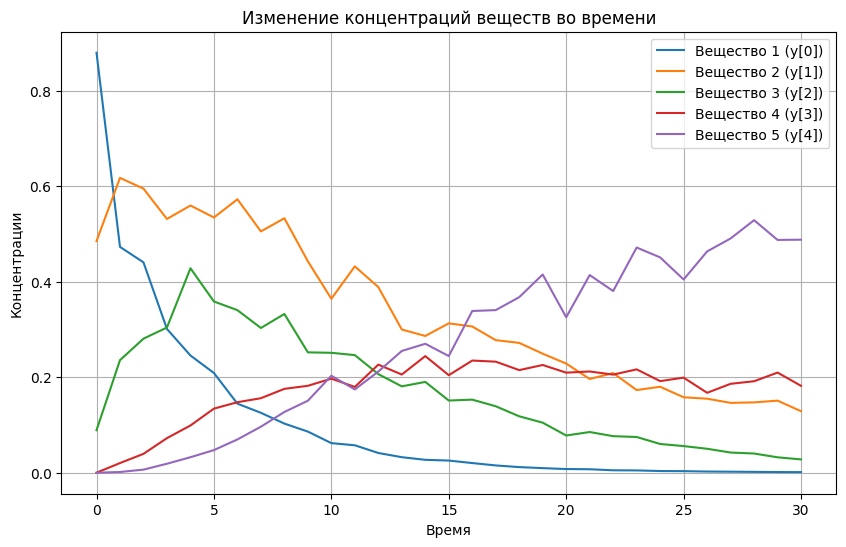

In [26]:
# Генерация шума
noise_level = 5e-2                # Уровень шума

time_vec = sol.t.reshape(-1, 1)   # Изменение формата временного шага для метода из sklearn

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    noise = np.random.randn(*sol.y[i].shape) * sol.y[i] * noise_level
    sol.y[i] = sol.y[i] + noise
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()


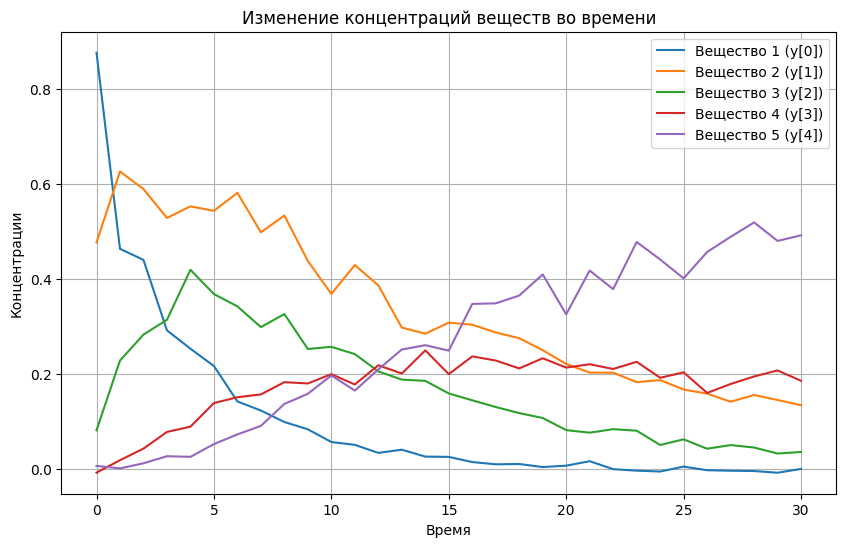

In [28]:
# Генерация шума
relative_noise_scale = 0.01  # Относительная амплитуда шума (например, 20% от значения функции)

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    noise = np.random.uniform(-relative_noise_scale, relative_noise_scale, size=sol.y[i].shape)
    sol.y[i] = sol.y[i] + noise
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()


# Построение полиномиальных аппроксимаций функций изменения концентраций

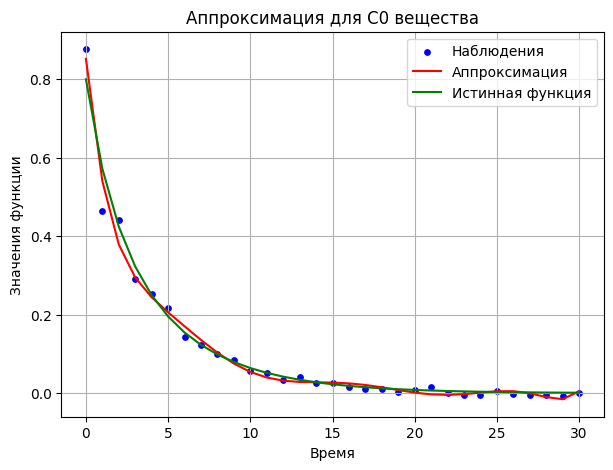

Для C0 вещества:
--------------------------------------------------
Коэффициент детерминации R^2: 0.98840368
Коэффициенты полинома:
[[ 0.00000000e+00 -4.22348297e-01  1.31924011e-01 -2.39764285e-02
   2.50648513e-03 -1.53264216e-04  5.41344945e-06 -1.02234375e-07
   7.98633715e-10]]
Свободный член: 0.85223798



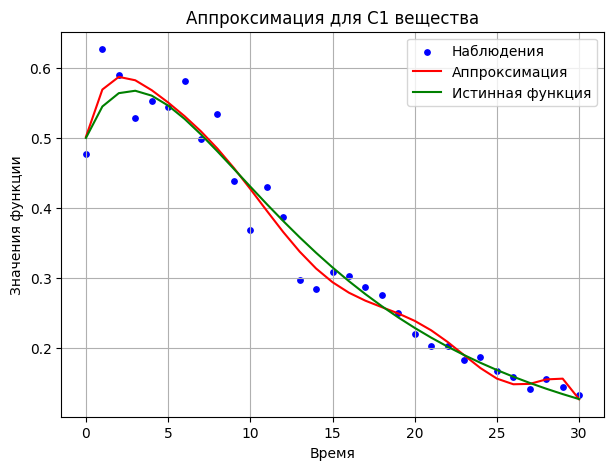

Для C1 вещества:
--------------------------------------------------
Коэффициент детерминации R^2: 0.96998358
Коэффициенты полинома:
[[ 0.00000000e+00  1.05470110e-01 -4.65361460e-02  9.60573257e-03
  -1.15697106e-03  8.07459519e-05 -3.19196841e-06  6.61731715e-08
  -5.58227242e-10]]
Свободный член: 0.50158076



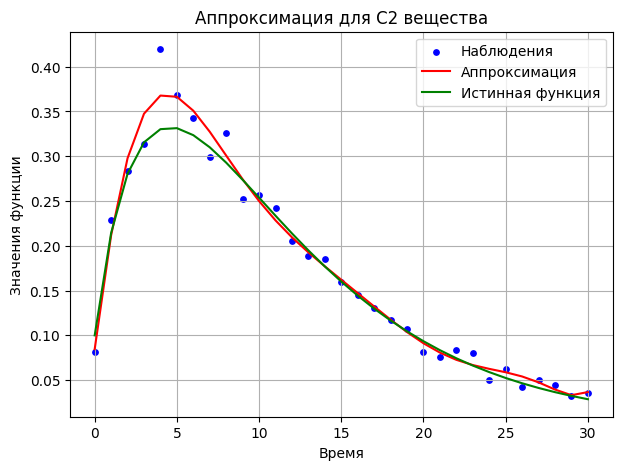

Для C2 вещества:
--------------------------------------------------
Коэффициент детерминации R^2: 0.98087837
Коэффициенты полинома:
[[ 0.00000000e+00  1.48051980e-01 -2.06565634e-02 -5.82971331e-04
   3.31697918e-04 -3.03210402e-05  1.30091745e-06 -2.75558786e-08
   2.32046715e-10]]
Свободный член: 0.08458364



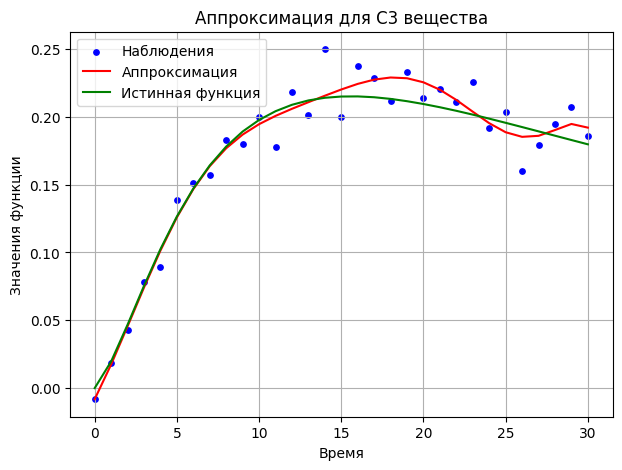

Для C3 вещества:
--------------------------------------------------
Коэффициент детерминации R^2: 0.95918767
Коэффициенты полинома:
[[ 0.00000000e+00  2.36705811e-02  2.18592960e-03 -2.44230135e-04
  -3.97761108e-05  7.04690454e-06 -4.11713723e-07  1.06783759e-08
  -1.04101568e-10]]
Свободный член: -0.00816683



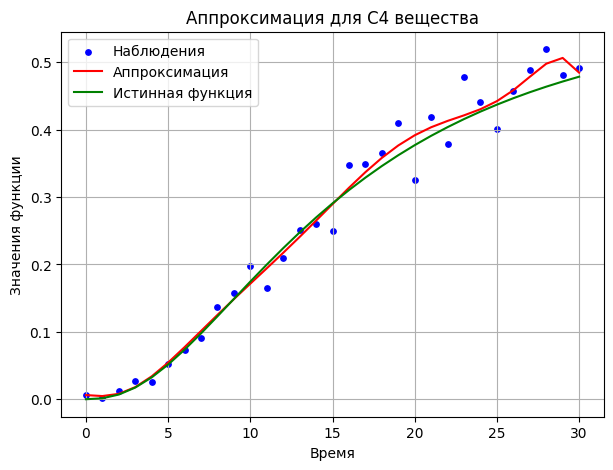

Для C4 вещества:
--------------------------------------------------
Коэффициент детерминации R^2: 0.97964680
Коэффициенты полинома:
[[ 0.00000000e+00 -2.21225842e-03 -4.71143984e-04  1.50180910e-03
  -2.85992291e-04  2.49132558e-05 -1.13675468e-06  2.62149245e-08
  -2.40732648e-10]]
Свободный член: 0.00613752



In [29]:

# Преобразование признаков в полиномиальные
poly = PolynomialFeatures(degree=8)
t_poly = poly.fit_transform(time_vec)

reaction_poly_coeffs = np.zeros((5, 9))  # Массив из 5 строк и 9 столбцов. Столбцы отвечают за количество коэффициентов полинома, 
                                         # строки за концентрации веществ

for i in range(N_SUBSTANCE):
    y = sol.y[i].reshape(-1, 1)  # значения функции как 2D массив

    # Создаем и обучаем модель полиномиальной регрессии
    model = LinearRegression()
    model.fit(t_poly, y)
    y_pred = model.predict(t_poly)

    # Создаем отдельный график для каждого вещества
    plt.figure(figsize=(7, 5))  # Новый график
    plt.scatter(time_vec, y, color='blue', label='Наблюдения', s=15)
    plt.plot(time_vec, y_pred, color='red', label='Аппроксимация')
    plt.plot(time_vec, true_values[i], color='green', label=f'Истинная функция')

    plt.title(f'Аппроксимация для C{i} вещества')
    plt.xlabel('Время')
    plt.ylabel('Значения функции')
    plt.legend()
    plt.grid()
    plt.show()

    # Параметры модели
    r2 = model.score(t_poly, y)
    print(f"Для C{i} вещества:")
    print("-" * 50)  # разделитель
    print(f"Коэффициент детерминации R^2: {r2:.8f}")
    print("Коэффициенты полинома:")
    print(model.coef_)
    print(f"Свободный член: {model.intercept_[0]:.8f}")
    print()

    # Сохранение полиномов
    reaction_poly_coeffs[i, :] = model.coef_[0]
    reaction_poly_coeffs[i][0] = model.intercept_[0]



В данном примере отображается 9 коэффициентов полинома [[ 0.00000000e+00  6.74674994e-04  8.56524224e-04  4.89155055e-04  -6.89525452e-05
  3.62031426e-06  -7.85608142e-08  2.90939526e-10  8.03842604e-12]]

Здесь первый элемент `model.coef_[0]` = `0.00000000e+00` соответствует \(x^0\). Он, равен `0`, так как свободный член отдельно хранится в `model.intercept_`.

### Визуализация полиномов в более презентабельном виде

In [30]:
# Функция для форматирования полинома
def format_polynomial(coefficients):
    terms = []
    for power, coef in enumerate(coefficients):
        if abs(coef) > 1e-10:  # Пропускать практически нулевые коэффициенты
            term = f"{coef:.5e}" if power == 0 else f"{coef:.5e}t^{power}"
            terms.append(term)
    return " + ".join(terms).replace("+ -", "- ")  # Убираем лишние плюсы перед отрицательными числами

# Генерация и вывод полиномов
for i, coeffs in enumerate(reaction_poly_coeffs):
    print(f"C{i}(t) = ", end='')
    print(format_polynomial(coeffs))


C0(t) = 8.52238e-01 - 4.22348e-01t^1 + 1.31924e-01t^2 - 2.39764e-02t^3 + 2.50649e-03t^4 - 1.53264e-04t^5 + 5.41345e-06t^6 - 1.02234e-07t^7 + 7.98634e-10t^8
C1(t) = 5.01581e-01 + 1.05470e-01t^1 - 4.65361e-02t^2 + 9.60573e-03t^3 - 1.15697e-03t^4 + 8.07460e-05t^5 - 3.19197e-06t^6 + 6.61732e-08t^7 - 5.58227e-10t^8
C2(t) = 8.45836e-02 + 1.48052e-01t^1 - 2.06566e-02t^2 - 5.82971e-04t^3 + 3.31698e-04t^4 - 3.03210e-05t^5 + 1.30092e-06t^6 - 2.75559e-08t^7 + 2.32047e-10t^8
C3(t) = -8.16683e-03 + 2.36706e-02t^1 + 2.18593e-03t^2 - 2.44230e-04t^3 - 3.97761e-05t^4 + 7.04690e-06t^5 - 4.11714e-07t^6 + 1.06784e-08t^7 - 1.04102e-10t^8
C4(t) = 6.13752e-03 - 2.21226e-03t^1 - 4.71144e-04t^2 + 1.50181e-03t^3 - 2.85992e-04t^4 + 2.49133e-05t^5 - 1.13675e-06t^6 + 2.62149e-08t^7 - 2.40733e-10t^8


### Этап, аналогичный предыдущему, но с выводом графиков концентраций более компактно, на один лист

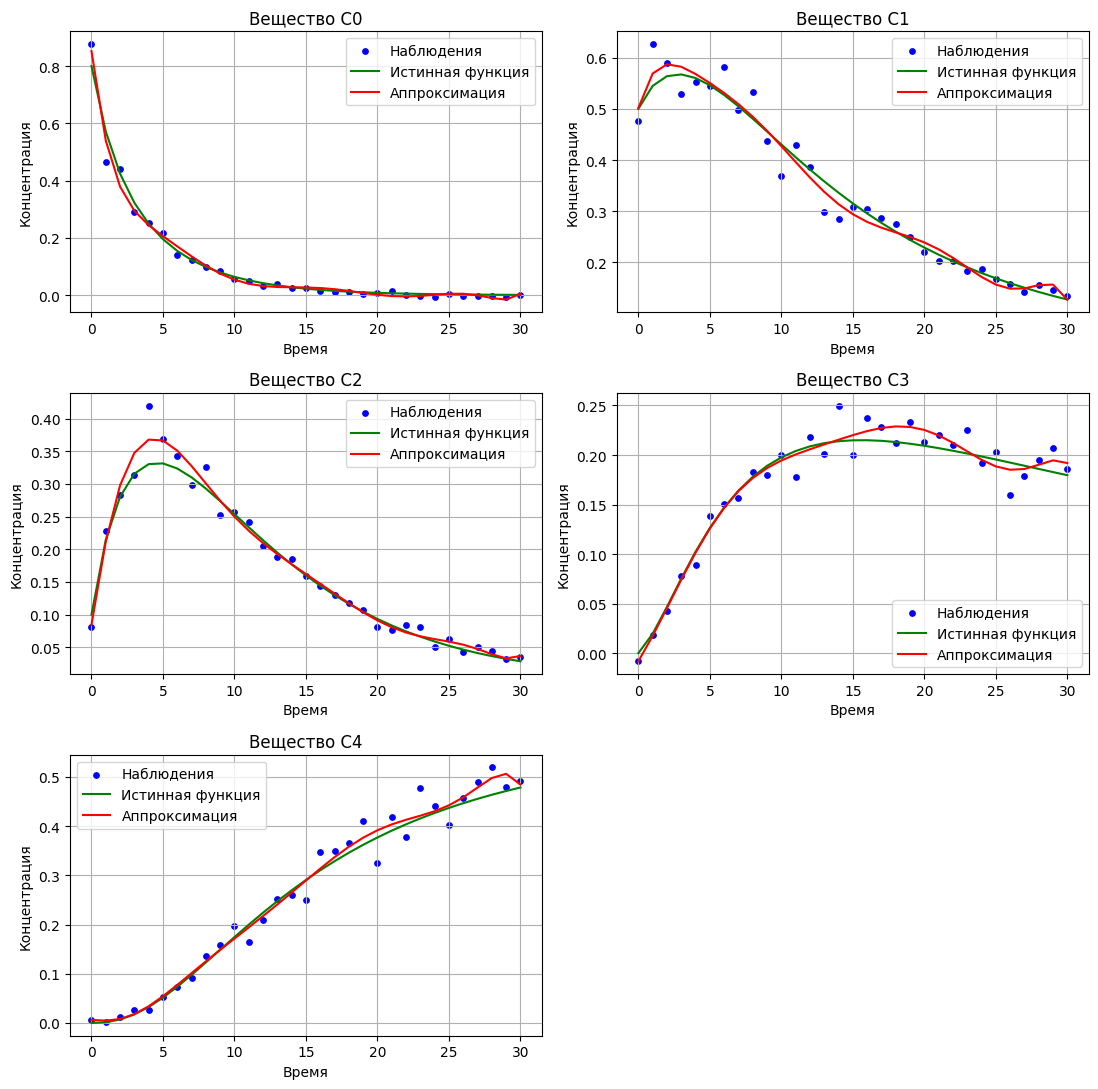

In [31]:
# Преобразование признаков в полиномиальные
poly = PolynomialFeatures(degree=8)
t_poly = poly.fit_transform(time_vec)

# Определяем количество строк и столбцов для сетки графиков
rows, cols = (3, 2)  # Подходит для N_SUBSTANCE = 6
fig, axes = plt.subplots(rows, cols, figsize=(11,11))  # Размер общего окна

# Перебираем вещества и оси для графиков
for i in range(N_SUBSTANCE):
    y = sol.y[i].reshape(-1, 1)  # значения функции как 2D массив

    # Создаем и обучаем модель полиномиальной регрессии
    model = LinearRegression()
    model.fit(t_poly, y)
    y_pred = model.predict(t_poly)

    # Определяем текущую ось
    ax = axes[i // cols, i % cols]
    
    # Строим график
    ax.scatter(time_vec, y, color='blue', label='Наблюдения', s=15)
    ax.plot(sol.t, true_values[i], color='green', label=f'Истинная функция')
    ax.plot(time_vec, y_pred, color='red', label='Аппроксимация')
    
    # Настройка графика
    ax.set_title(f'Вещество C{i}')
    ax.set_xlabel('Время')
    ax.set_ylabel('Концентрация')
    ax.legend()
    ax.grid()

# Убираем пустые графики, если их больше нет
for j in range(N_SUBSTANCE, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()  # Автоматическая подгонка расстояний
plt.show()


### Добавим вычисление MSE и скалярного произведения между истинной и аппрокcимационной функциями

Для C0-го вещества:
MSE: 0.0730773958859172
Скалярное произведение: 1.5127695198913462
Косинус угла (нормализованное скалярное произведение): 0.9997411709616287
--------------------------------------------------

Для C1-го вещества:
MSE: 0.044821799042157634
Скалярное произведение: 4.178302707435257
Косинус угла (нормализованное скалярное произведение): 0.9999281981610323
--------------------------------------------------

Для C2-го вещества:
MSE: 0.021840569492448673
Скалярное произведение: 1.185690548793233
Косинус угла (нормализованное скалярное произведение): 0.9996767597732625
--------------------------------------------------

Для C3-го вещества:
MSE: 0.006815390300272335
Скалярное произведение: 1.003729154634681
Косинус угла (нормализованное скалярное произведение): 0.9997742195681656
--------------------------------------------------

Для C4-го вещества:
MSE: 0.051927983147443554
Скалярное произведение: 2.8709614433877864
Косинус угла (нормализованное скалярное произведение): 0

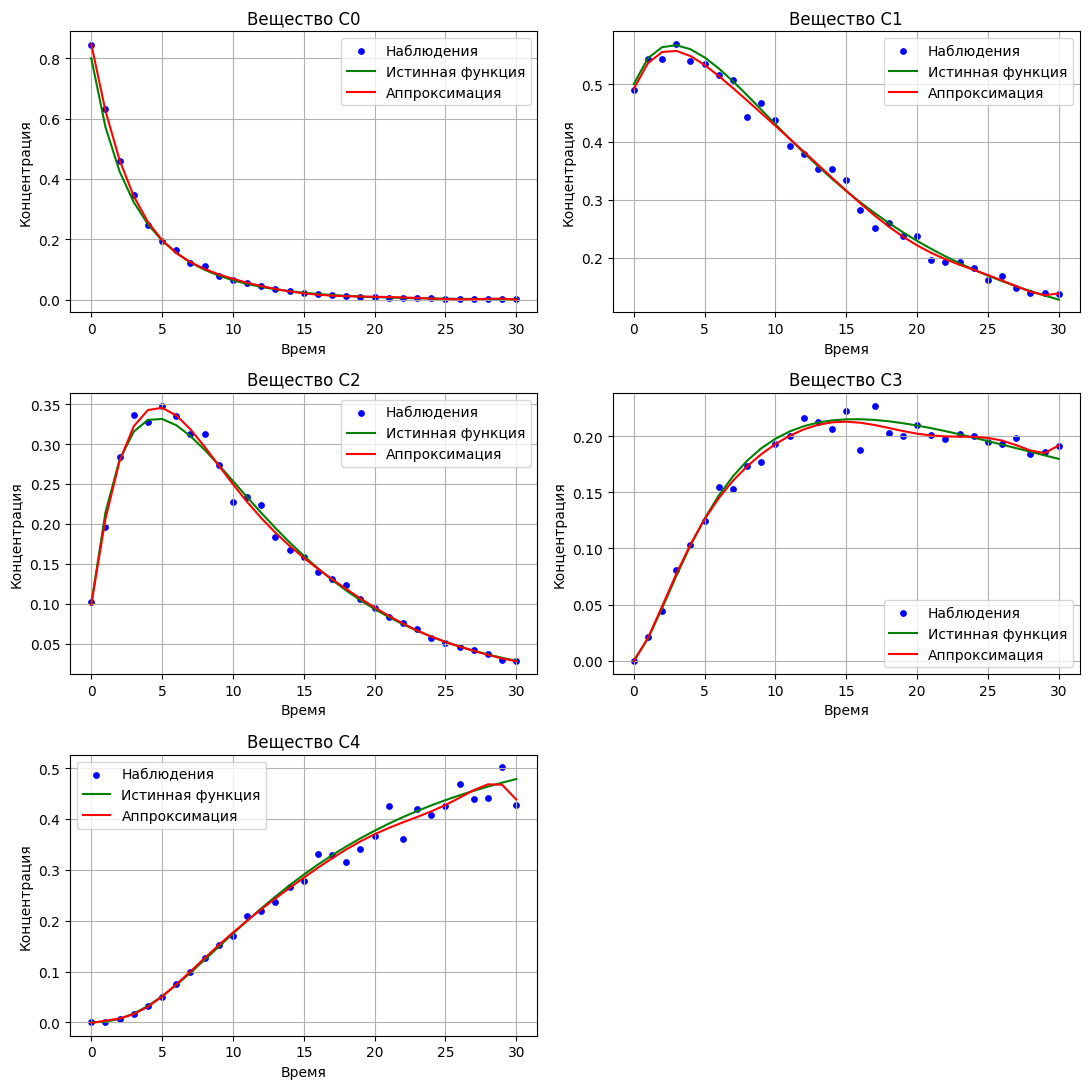

In [42]:
# Преобразование признаков в полиномиальные
poly = PolynomialFeatures(degree=8)
t_poly = poly.fit_transform(time_vec)

# Определяем количество строк и столбцов для сетки графиков
rows, cols = (3, 2)  # Подходит для N_SUBSTANCE = 6
fig, axes = plt.subplots(rows, cols, figsize=(11,11))  # Размер общего окна

# Перебираем вещества и оси для графиков
for i in range(N_SUBSTANCE):
    y = sol.y[i].reshape(-1, 1)  # значения функции как 2D массив

    # Создаем и обучаем модель полиномиальной регрессии
    model = LinearRegression()
    model.fit(t_poly, y)
    y_pred = model.predict(t_poly)

    # MSE
    mse = np.mean((y_pred - true_values[i])**2)
    print(f'Для C{i}-го вещества:')
    print("MSE:", mse)

    # Скалярное произведение и косинус угла
    dot_product = np.sum(y_pred.flatten() * true_values[i])  # Скалярное произведение
    norm_true = np.sqrt(np.sum(true_values[i]**2))   # Норма истинной функции
    norm_approx = np.sqrt(np.sum(y_pred**2))         # Норма аппроксимации
    cos_theta = dot_product / (norm_true * norm_approx)

    print("Скалярное произведение:", dot_product)
    print("Косинус угла (нормализованное скалярное произведение):", cos_theta)
    print('-' * 50)
    print()

    # Определяем текущую ось
    ax = axes[i // cols, i % cols]
    
    # Строим график
    ax.scatter(time_vec, y, color='blue', label='Наблюдения', s=15)
    ax.plot(sol.t, true_values[i], color='green', label=f'Истинная функция')
    ax.plot(time_vec, y_pred, color='red', label='Аппроксимация')
    
    # Настройка графика
    ax.set_title(f'Вещество C{i}')
    ax.set_xlabel('Время')
    ax.set_ylabel('Концентрация')
    ax.legend()
    ax.grid()

# Убираем пустые графики, если их больше нет
for j in range(N_SUBSTANCE, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()  # Автоматическая подгонка расстояний
plt.show()


# Нахождение производных от функций концентраций веществ

Так как в нашем случае в качестве функций используются только полиномы, то я напишу функцию вручную

`print(reaction_poly_coeffs)` - чтобы посмотреть массив с коэффициентами полиномов для каждого вещества

In [43]:
def differentiate_polynomial(coefficients):
    degree = len(coefficients) # степень полинома + 1
    return np.array([coefficients[i] * i for i in range(1, degree)])

reaction_poly_derivatives = np.array([differentiate_polynomial(coeff) for coeff in reaction_poly_coeffs])

print(reaction_poly_derivatives)

[[-2.53248522e-01  6.92115389e-02 -6.41170302e-03  4.18660334e-06
   3.82978287e-05 -2.64305604e-06  7.32273446e-08 -7.47645501e-10]
 [ 6.03300352e-02 -3.56768296e-02  5.95777681e-03 -4.54670523e-04
   1.23209763e-05  2.91448143e-07 -2.23273988e-08  3.26876026e-10]
 [ 1.26221789e-01 -3.93333496e-02  1.86716975e-03  3.36655166e-04
  -4.63724379e-05  2.34341197e-06 -5.46841543e-08  4.92115682e-10]
 [ 1.37065943e-02  1.85194953e-02 -7.39857952e-03  1.20225576e-03
  -1.03050122e-04  4.81878814e-06 -1.15602641e-07  1.11073485e-09]
 [ 7.63899314e-03 -1.03264747e-02  7.07280973e-03 -1.40342514e-03
   1.32444651e-04 -6.57289893e-06  1.65154931e-07 -1.65425523e-09]]


По формуле:

<div style="text-align: center;">

$$\frac{d\vec{C}}{dt}=S\cdot\vec{W}$$

</div>

Имеется зависимость между 3 переменными, две из которых мы знаем. Остается выразить $\vec{W}$ из этого уравнения, и получить его численно

В ходе преобразований получается:

<div style="text-align: center;">

$$\vec{W} = (S^\top S)^{-1} S^\top\frac{d\vec{C}}{dt}$$

</div>

А это уже МНК. 

Посчитаю вектор приращений в точке

In [75]:
# Точка в которой счиатем значения
t_1 = 0.5
t_2 = 6
t_3 = 15

# Вычисление значения полиномов в точке t
dC_1 = np.array([np.polyval(substance[::-1], t_1) for substance in reaction_poly_derivatives])
dC_2 = np.array([np.polyval(substance[::-1], t_2) for substance in reaction_poly_derivatives])
dC_3 = np.array([np.polyval(substance[::-1], t_3) for substance in reaction_poly_derivatives])

print('Производные концентраций в моменты времени:')
print('dC(t=0.5) = ', dC_1)
print('dC(t=6)   = ', dC_2)
print('dC(t=12)  = ', dC_3)

W_1 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_1  # Скорости реакций в момент времени t_1 = 0.5
W_2 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_2  # Скорости реакций в момент времени t_2 = 6
W_3 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_3  # Скорости реакций в момент времени t_3 = 12

print()
print('Вектора скоростей реакций в моменты времени:')
print('W(t=0.5) = ', W_1)
print('W(t=6)   = ', W_2)
print('W(t=12)  = ', W_3)

C_1 = np.array([np.polyval(substance[::-1], t_1) for substance in reaction_poly_coeffs])
C_2 = np.array([np.polyval(substance[::-1], t_2) for substance in reaction_poly_coeffs])
C_3 = np.array([np.polyval(substance[::-1], t_3) for substance in reaction_poly_coeffs])

print()
print('Концентрации в моменты времени:')
print('C(t=0.5) = ', C_1)
print('C(t=6)   = ', C_2)
print('C(t=12)  = ', C_3)

Производные концентраций в моменты времени:
dC(t=0.5) =  [-0.22024284  0.04392501  0.10706116  0.02126069  0.00407661]
dC(t=6)   =  [-0.03560751 -0.02017573 -0.01413257  0.01699726  0.02494125]
dC(t=12)  =  [-0.00545895 -0.02224097 -0.0143344  -0.00022023  0.01985242]

Вектора скоростей реакций в моменты времени:
W(t=0.5) =  [0.04545198 0.12984882 0.02329758 0.00254682]
W(t=6)   =  [0.00422506 0.02726548 0.04150614 0.02461697]
W(t=12)  =  [-0.00084534  0.006841    0.02086675  0.02077834]

Концентрации в моменты времени:
C(t=0.5) =  [0.72844937 0.51794124 0.15723742 0.00835372 0.00170347]
C(t=6)   =  [0.15449929 0.51404219 0.33582377 0.14471673 0.0745156 ]
C(t=12)  =  [0.02073781 0.3156618  0.15754812 0.21274755 0.28458454]


In [76]:
MATR_PLUS = np.where(MATR < 0, -MATR, 0)
print(MATR_PLUS)

[[2 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 1 0]]


In [77]:
# Вычисление вектора с использованием заданной формулы
result_1 = np.prod(C_1 ** MATR_PLUS, axis=1)
result_2 = np.prod(C_2 ** MATR_PLUS, axis=1)
result_3 = np.prod(C_3 ** MATR_PLUS, axis=1)

In [78]:
print(W_1/result_1)
print(W_2/result_2)
print(W_3/result_3)

[0.08565526 0.17825373 0.14816817 0.58862434]
[0.17700275 0.1764764  0.12359502 0.33091554]
[-1.96565776  0.32988048  0.13244686  0.30940287]


In [70]:
k

tensor([0.1000, 0.2000, 0.1300, 0.3000])